In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
def plot_img(img):
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

In [3]:
part1_single_objects = "COTSDataset/Part 1 - Single Objects"
part2_multiple_objects = "COTSDataset/Part 2 - Multiple Objects"
part3_complex_background = "COTSDataset/Part 3 - Complex Background"

In [4]:
img_path = os.path.join(part2_multiple_objects, "academic_book_no", "1_colour.jpeg")
# img_path = os.path.join(part2_multiple_objects, "academic_book_no", "2_colour.jpeg")
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask_path = os.path.join(part2_multiple_objects, "academic_book_no", "masks", "ac_3_colour_mask_7_mask.png")
# mask_path = os.path.join(part2_multiple_objects, "academic_book_no", "masks", "ac_3_colour_mask_8_mask.png")
mask = cv2.imread(mask_path)

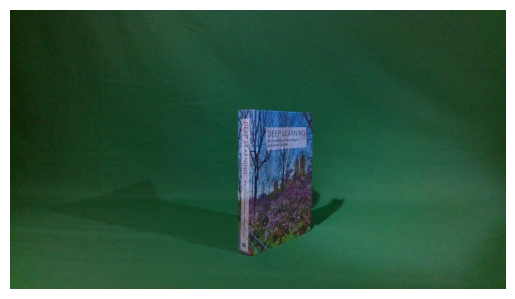

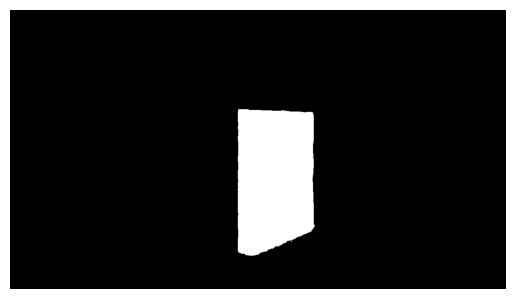

In [5]:
plot_img(img)
plot_img(mask)

In [6]:
from custom_env import ImageSegmentationEnv
from localization_env import ObjectLocalizationEnv

In [7]:
# Extracting target bounding box from mask
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
mask = mask.astype(np.uint8)
# Find contours in the mask
contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Initialize an empty list to store bounding boxes
bounding_boxes = []

# Loop through the detected contours
for cnt in contours:
    # Get the bounding box for each contour
    x, y, w, h = cv2.boundingRect(cnt)
    
    # Add the bounding box coordinates to the list
    bounding_boxes.append((x, y, x + w, y + h))

# Find the minimum and maximum coordinates to create a bounding box around all masks
x1, y1 = min(box[0] for box in bounding_boxes), min(box[1] for box in bounding_boxes)
x2, y2 = max(box[2] for box in bounding_boxes), max(box[3] for box in bounding_boxes)

# Create the target bounding box that encompasses all masks
target_bbox = np.array([x1, y1, x2, y2])


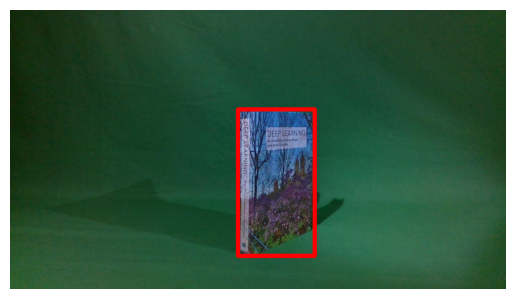

In [8]:
# Plotting image and target bounding box with cv2.rectangle
img_copy = img.copy()
img_copy = cv2.rectangle(img_copy, (x, y), (x+w, y+h), (255, 0, 0), 9)

plot_img(img_copy)

In [9]:
env = ObjectLocalizationEnv(img, target_bbox)

c:\Users\User\anaconda3\envs\ComputerVision\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\anaconda3\envs\ComputerVision\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# Access the initial observation (grayscale image) by resetting the environment
initial_observation = env.reset()

initial_observation

(array([-1.5889091 , -1.9776528 , -1.280345  , ..., -0.79480636,
        -0.86249053, -0.11786045], dtype=float32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8))

In [11]:
# # Creating gym loop for testing and sampling random action

# for i in range(10):
#     action = env.action_space.sample()
#     new_observation, reward, terminated, truncated,  _ = env.step(action)
#     env.render()
#     print(action, reward)

In [12]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from collections import namedtuple, deque
import random

# Define a named tuple for storing a single experience
Experience = namedtuple("Experience", ["state", "action", "next_state", "reward", "done"])

# Define the replay buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)

    def push(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

# Define a simple neural network for DQN
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the DQN agent
class DQNAgent:
    def __init__(self, input_size, output_size, replay_buffer_size=10000, batch_size=32, gamma=0.99,
                 epsilon_start=1.0, epsilon_final=0.01, epsilon_decay=0.995, target_update=10):
        self.input_size = input_size
        self.output_size = output_size
        self.replay_buffer = ReplayBuffer(replay_buffer_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_final = epsilon_final
        self.epsilon_decay = epsilon_decay
        self.target_update = target_update

        self.policy_net = DQN(input_size, output_size)
        self.target_net = DQN(input_size, output_size)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=1e-3)

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.choice(range(self.output_size))  # Explore
        else:
            with torch.no_grad():
                return self.policy_net(state).max(0)[1].view(1, 1).item()  # Exploit

    def update(self):
        if len(self.replay_buffer) < self.batch_size:
            return

        experiences = self.replay_buffer.sample(self.batch_size)
        batch = Experience(*zip(*experiences))

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat([a.unsqueeze(0) for a in batch.action])
        print(batch.next_state)
        next_state_batch = torch.cat(batch.next_state)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.cat(batch.done)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)
        next_state_values = self.target_net(next_state_batch).max(1)[0].detach()
        expected_state_action_values = (next_state_values * self.gamma) * (1 - done_batch) + reward_batch

        loss = nn.functional.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_final:
            self.epsilon *= self.epsilon_decay

        if self.target_update > 0 and self.target_update % 10 == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

input_size = len(env.get_state()[0])
output_size = env.action_space.n
agent = DQNAgent(input_size, output_size)

# Training loop
num_episodes = 100
for episode in range(num_episodes):
    state = env.reset()
    state = torch.Tensor(state[0]).view(1, -1)  # Convert the state to a PyTorch tensor
    total_reward = 0

    while True:
        action = agent.select_action(state)
        next_state, reward, truncated, terminated, _ = env.step(action)
        # env.render()
        done = truncated or terminated
        next_state = torch.Tensor(next_state[0]).view(1, -1)
        total_reward += reward

        # When storing an experience in the replay buffer, make sure the action is a PyTorch tensor.
        agent.replay_buffer.push((state, torch.tensor(action), next_state, reward, torch.Tensor([done])))


        state = next_state
        agent.update()

        if done:
            break

    print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {total_reward}")


Episode 1/100, Total Reward: 0.0
Episode 2/100, Total Reward: 0.0
Episode 3/100, Total Reward: 1.0
Episode 4/100, Total Reward: 2.0
Episode 5/100, Total Reward: 1.0
(tensor([[-0.6136, -2.3362, -0.4690,  ..., -0.6196, -1.2162,  0.3053]]), tensor([[14., 39.,  9.,  ..., 34., 72., 35.]]), tensor([[-1.4828, -1.3461, -0.5597,  ..., -0.5544, -1.3307,  0.4426]]), tensor([[-0.6970, -1.2294, -0.6412,  ..., -0.2793, -0.1124, -0.3060]]), tensor([[-0.6841, -2.3672, -0.8000,  ...,  0.2368, -1.0347, -0.1729]]), tensor([[-1.6710, -1.1252, -0.1744,  ..., -0.5929, -1.1387, -0.8532]]), tensor([[-1.1664, -2.5188, -0.6059,  ..., -0.5500, -0.8242, -0.5346]]), tensor([[14., 39.,  9.,  ..., 34., 72., 35.]]), tensor([[-1.8064, -2.6021, -1.0050,  ..., -0.6188, -0.0153, -0.4345]]), tensor([[-1.0940, -2.4158, -0.6827,  ..., -0.5321, -1.2806, -0.7782]]), tensor([[-0.8142, -1.8833, -1.0218,  ..., -0.7350, -0.7686,  0.5134]]), tensor([[-1.6057, -1.4426, -0.6430,  ..., -0.4476, -0.9079, -0.4209]]), tensor([[-1.0698, 

RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 4096 but got size 3840 for tensor number 1 in the list.

In [13]:
# import itertools
# GAMMA = 0.99
# BATCH_SIZE = 128
# BUFFER_SIZE = 10000
# MIN_REPLAY_SIZE = 5000
# EPS_START = 0.9
# EPS_END = 0.05
# EPS_DECAY = 0.997
# TARGET_UPDATE_FREQ = 5

# obs = env.reset()
# episode_reward = 0.0

# Transition = namedtuple('Transition', ('states', 'actions', 'rewards', 'dones', 'next_states'))

# class Replay_memory():

#     def __init__(self, env, fullsize, minsize, batchsize):
#         self.env = env
#         self.memory = deque(maxlen=fullsize)
#         self.rewards = deque(maxlen=50)
#         self.batchsize = batchsize
#         self.minsize = minsize

#     def append(self, transition):
#         self.memory.append(transition)

#     def sample_batch(self):
#         batch = random.sample(self.memory, self.batchsize)
#         batch = Transition(*zip(*batch))
#         states = torch.from_numpy(np.array(batch.states, dtype=np.float32))
#         actions = torch.from_numpy(np.array(batch.actions, dtype=np.int64)).unsqueeze(1)
#         rewards = torch.from_numpy(np.array(batch.rewards, dtype=np.float32)).unsqueeze(1)
#         dones = torch.from_numpy(np.array(batch.dones, dtype=np.bool8)).unsqueeze(1)
#         next_states = torch.from_numpy(np.array(batch.next_states, dtype=np.float32))
#         return states, actions, rewards, dones, next_states

#     def initialize(self):
#         obs, info = env.reset()
#         for _ in range(self.minsize):
#             action = self.env.action_space.sample()
#             new_obs, reward, terminated, truncated, info = env.step(action)
#             done = terminated or truncated
#             transition = Transition(obs, action, reward, done, new_obs)
#             self.append(transition)
#             obs = new_obs
#             if done:
#                 self.env.reset()
#         return self
    
# replay_memory = Replay_memory(env, BUFFER_SIZE, MIN_REPLAY_SIZE, BATCH_SIZE).initialize()

# class DQN(nn.Module):
#     def __init__(self, ninputs, noutputs):
#         super(DQN, self).__init__()
#         self.a1 = nn.Linear(ninputs, 64)
#         self.a2 = nn.Linear(64, noutputs)

#     def forward(self, X):
#         o = self.a1(X)
#         o = torch.tanh(o)
#         o = self.a2(o)
#         return o

#     def __call__(self, X):
#         return self.forward(X)
    
# dqn_policy = DQN(env.observation_space.shape[0], env.action_space.n)
# dqn_target = DQN(env.observation_space.shape[0], env.action_space.n)
# dqn_target.load_state_dict(dqn_policy.state_dict())
# dqn_target.eval()

# loss_fn = nn.MSELoss()
# learning_rate = 0.001
# optimizer = torch.optim.Adam(dqn_policy.parameters(), lr=learning_rate)

# def epsilon_greedy_policy(epsilon, obs):
#     rnd_sample = random.random()
#     if rnd_sample <= epsilon:
#         action = env.action_space.sample()
#     else:
#         with torch.no_grad():
#             action = int(torch.argmax(dqn_policy(torch.Tensor(obs))))
#     return action

# obs, info = env.reset()
# eps_threshold =EPS_START
# episode = 1

# for step in itertools.count():
#     action = epsilon_greedy_policy(eps_threshold, obs)
#     new_obs, reward, terminated, truncated, _ = env.step(action)
#     done = terminated or truncated
#     replay_memory.append(Transition(obs, action, reward, done, new_obs))
#     episode_reward += reward
#     obs = new_obs

#     if done:
#         episode += 1
#         eps_threshold = np.max((eps_threshold*EPS_DECAY, EPS_END))
#         replay_memory.rewards.append(episode_reward)
#         obs, info = env.reset()
#         avg_res = np.mean(replay_memory.rewards)

#         if episode % 100 == 0:
#             avg_res = np.mean(replay_memory.rewards)
#             print(f'Episode: {episode} Avg Results: {avg_res} Epsilon: {eps_threshold}')

#         if avg_res >= 400:
#             print(f'Solved at episode: {episode} Avg Results: {avg_res}')
#             break
#         episode_reward = 0

#     b_states, b_actions, b_rewards, b_dones, b_next_states = replay_memory.sample_batch()

#     qvalues = dqn_policy(b_states).gather(1, b_actions)

#     with torch.no_grad():
#         target_qvalues = dqn_target(b_next_states)
#         max_target_qvalues = torch.max(target_qvalues, axis=1).values.unsqueeze(1)
#         expected_qvalues = b_rewards + GAMMA * (1 - b_dones.type(torch.int64)) * max_target_qvalues

#     loss = loss_fn(qvalues, expected_qvalues)
#     optimizer.zero_grad()
#     loss.backward()
#     for param in dqn_policy.parameters():
#         param.grad.data.clamp_(-1, 1)
#     optimizer.step()

#     if episode % TARGET_UPDATE_FREQ == 0:
#         dqn_target.load_state_dict(dqn_policy.state_dict())


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (128,) + inhomogeneous part.